먼저 필요한 라이브러리를 호출합니다.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

이 예제는 케라스에 내장되어 제공하는 MNIST 데이터셋을 사용합니다.

MNIST 데이터셋을 내려받은 후 텐서로 변경하고 데이터로더에 전달합니다.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(
    root='./MNIST_DATA',
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root='./MNIST_DATA',
    train=False,
    transform=transform,
    download=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4
)

100.0%


Extracting ./MNIST_DATA\MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST_DATA\MNIST\raw



100.0%

Extracting ./MNIST_DATA\MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST_DATA\MNIST\raw




100.0%


Extracting ./MNIST_DATA\MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST_DATA\MNIST\raw



100.0%

Extracting ./MNIST_DATA\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST_DATA\MNIST\raw



`데이터로더`는 전체 데이터셋을 작은 단위로 쪼개서 메모리로 가져올 때 사용합니다. 데이터로더에서 사용하는 파라미터는 다음과 같습니다.

* 첫 번째 파라미터 : 훈련 데이터셋

* `batch_size` : 메모리로 한 번에 불러올 데이터의 크기

* `num_workers` : 데이터를 불러올 때 몇 개의 프로세스를 사용할지 지정하는 부분으로 병렬로 데이터를 불러오겠다는 의미입니다. 일반적으로 GPU를 사용할 때 많이 사용하는 파라미터입니다. `너무 많은 값을 할당하면 오버헤드`가 발생할 수 있고, 작게 할당하면 좋은 성능을 기대할 수 없으므로 적절한 값을 지정해야 합니다. 일반적으로 `4 * GPU 개수`를 지정하지만 모든 상황에 적합한 것은 아니므로 주의해서 사용할 필요가 있습니다.

* `pin_memory` : CPU를 사용하다 GPU로 전환할 때 속도 향상을 위해 사용합니다. 따라서 모델 훈련과정에서 CPU나 GPU만 사용한다면 True로 지정할 필요가 없는 파라미터입니다. pin_memory를 True로 지정하면 훈련에 사용할 데이터셋을 GPU에 미리 불러와서 학습시키기 때문에 속도가 향상됩니다.


이제 모델의 네트워크를 생성해 볼 텐데 인코더와 디코더를 사용하여 간단한 오토인코더를 만들어 봅시다. 이때 `데이터셋을 저차원으로 압축하는 것을 인코더`라고 하며, 압축한 것을 다시 `원래의 차원으로 복원하는 것을 디코더`라고 합니다. 따라서 인코더와 디코더에서 사용하는 네트워크 계층은 같아야 합니다.

In [3]:
## 네트워크(신경망) 생성
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()

        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1,8,3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

        self.flatten = nn.Flatten(start_dim=1) # 완전연결층
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim) # 출력 계층
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)) # 인코더의 완전 연결층에 대응
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1) # 인코더 합성곱층에 대응
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

인코더와 디코더 객체를 초기화하고, 모델의 훈련 과정에 필요한 손실 함수와 옵티마이저를 지정합니다.

In [4]:
encoder = Encoder(encoded_space_dim=4, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=4, fc2_input_dim=128)
encoder.to(device=device)
decoder.to(device=device)

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
] # 인코더와 디코더에서 사용할 파라미터를 다르게 지정

optim = torch.optim.Adam(params_to_optimize, lr=1e-3, weight_decay=1e-05)
loss_fn = torch.nn.MSELoss()

오토인코더에서 가장 널리 사용되는 손실 함수는 `평균 제곱 오차`와 `이진 크로스 엔트로피`입니다. 입력 값이(0,1) 범위에 있으면 이진 크로스 엔트로피를 사용하고, 그렇지 않으면 평균 제곱 오차를 사용합니다.

옵티마이저는 아담을 사용했지만 `RMSProp` 또는 `adadelta` 같은 옵티마이저를 이용하여 성능을 비교해 보는 것도 학습에 도움이 많이 되니, 옵션을 변경하여 테스트를 진행해 보기 바랍니다.

다음은 앞에서 생성한 모델 네트워크의 구조를 보여 줍니다.

In [5]:
print(decoder)

Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)


In [6]:
print(encoder)

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)


모델 학습에 대한 함수를 생성합니다.

In [7]:
import numpy as np

def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer, noise_factor=0.3):
    encoder.train() # 인코더 훈련
    decoder.train() # 디코더 훈련
    train_loss = []

    for image_batch, _ in dataloader: # 훈련 데이터셋을 이용하여 모델 학습(비지도 학습으로 레이블은 필요하지 않습니다.)
        image_noisy = add_noise(image_batch, noise_factor)
        image_noisy = image_noisy.to(device) # 데이터셋이 CPU/GPU 장치를 사용하도록 지정
        encoded_data = encoder(image_noisy) # 노이즈 데이터를 인코더의 입력으로 사용
        decoded_data = decoder(encoded_data) # 인코더 출력을 디코더의 입력으로 사용
        loss = loss_fn(decoded_data, image_noisy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

이제 모델을 검증(테스트)하기 위한 함수를 생성합니다.

In [8]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn, noise_factor=0.3):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        conc_out = [] # 각 배치에 대한 출력을 저장하기 위해 리스트 형식의 변수 정의
        conc_label = []

        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out) # 리스트 형식으로 저장된 모든 값을 하나의 텐서로 생성

        conc_label = torch.cat(conc_label)

        val_loss = loss_fn(conc_out, conc_label) # 손실 함수를 이용하여 오차 계산
    return val_loss.data

입력 데이터셋에 추가할 노이즈를 생성하기 위한 함수를 정의합니다.

In [9]:
def add_noise(inputs, noise_factor=0.3):
    noisy = inputs + torch.rand_like(inputs) * noise_factor
    noisy = torch.clip(noisy, 0., 1.)
    return noisy

* `torch.randn_like(inputs)`는 입력(inputs)과 동일한 크기의 노이즈 텐서를 생성하고자 할 때 사용합니다.

* `torch.clip`은 데이터 값의 범위를 조정할 때 사용합니다. `torch.clip`에서 사용하는 파라미터는 다음과 같은 의미를 같습니다.  

    ![](../Static/691.jpg)  

    * 첫 번째 파라미터: 값의 범위를 조정할 데이터셋

    * 두 번째 파라미터 : 데이터의 범위 중 최솟값을 의미하며 예제에서는 0을 사용했습니다.

    * 세 번째 파라미터 : 데이터의 범위 중 최댓값을 의미하며 예제에서는 1을 사용했습니다.

에포크가 진행될수록 노이즈 데이터로 새로운 이미지가 어떻게 만들어지는지 확인하기 위한 함수를 생성합니다. 시각화하여 보여 줄 이미지는 원래의 이미지, 노이즈가 적용되어 손상된 데이터(이미지), 노이즈 데이터를 이용하여 새롭게 생성된 데이터(이미지)입니다.

In [11]:
# 이미지 시각화
def plot_ae_outputs(encoder, decoder, n=5, noise_factor=0.3):
    plt.figure(figsize=(10, 4.5))
    for i in range(n):
        ax = plt.subplot(3, n, i+1) #subplot에서 사용하는 파라미터는 (행, 열, 인덱스)입니다. 3 x 5 형태의 이미지가 출력됩니다.
        img = test_dataset[i][0].unsqueeze(0)
        image_noisy = add_noise(img, noise_factor)
        image_noisy = image_noisy.to(device=device)

        encoder.eval()
        decoder.eval()

        with torch.no_grad():
            rec_img = decoder(encoder(image_noisy))

        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray') # 테스트 데이터셋을 출력

        ax.get_xaxis().set_visible(False) # set_visible(False)는 그래프의 눈금을 표시하지 않겠다는 의미
        ax.get_yaxis().set_visible(False)

        if i == n // 2:
            ax.set_title('원래 이미지')
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray') # 테스트 데이터셋에 노이즈가 적용된 결과를 출력
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        if i == n // 2:
            ax.set_title('노이즈가 적용되어 손상된 이미지')
            ax = plt.subplot(3, n, i + 1 + n + n)
            plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray') # 노이즈가 추가된 이미지를 인코더와 디코더에 적용한 결과를 출력
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('재구성된 이미지')

    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.7,
                        top=0.9,
                        wspace=0.3,
                        hspace=0.3)
    plt.show()


앞에서 정의해 두었던 함수를 이용하여 모델을 학습시킵니다. 이때 학습 과정 중에 생성된 이미지도 확인해 보겠습니다.

EPOCH 1/30
EPOCH 2/30
EPOCH 3/30
EPOCH 4/30
EPOCH 5/30
EPOCH 6/30
EPOCH 7/30
EPOCH 8/30
EPOCH 9/30
EPOCH 10/30
EPOCH 11/30
EPOCH 12/30
EPOCH 13/30
EPOCH 14/30
EPOCH 15/30
EPOCH 16/30
EPOCH 17/30
EPOCH 18/30
EPOCH 19/30
EPOCH 20/30
EPOCH 21/30
EPOCH 22/30
EPOCH 23/30
EPOCH 24/30
EPOCH 25/30
EPOCH 26/30
EPOCH 27/30
EPOCH 28/30
EPOCH 29/30
EPOCH 30/30

 EPOCH 30/30 	 train loss 0.027 	 val loss 0.044


c:\Users\aqs45\OneDrive\바탕 화면\repo\Python_AI\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aqs45\OneDrive\바탕 화면\repo\Python_AI\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aqs45\OneDrive\바탕 화면\repo\Python_AI\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aqs45\OneDrive\바탕 화면\repo\Python_AI\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aqs45\OneDrive\바탕 화면\repo\Python_AI\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 516

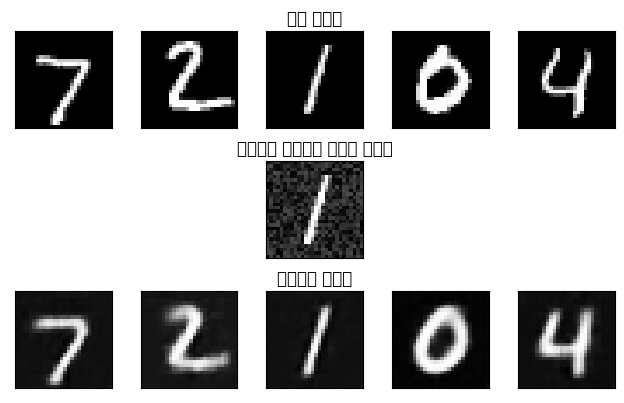

In [12]:
# 모델 학습
import numpy as np

num_epochs = 30
history_da = {'train_loss':[], 'val_loss':[]}
loss_fn = torch.nn.MSELoss()

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    train_loss = train_epoch(encoder=encoder, decoder=decoder, device=device, dataloader=train_loader, loss_fn=loss_fn, optimizer=optim, noise_factor=0.3)

    val_loss = test_epoch(encoder=encoder, decoder=decoder, device=device, dataloader=test_loader, loss_fn=loss_fn, noise_factor=0.3)

    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    plot_ae_outputs(encoder=encoder, decoder=decoder, noise_factor=0.3)